# ***Business Understanding***
- The primary objective of this NLP project is to develop a robust clssification model capable of accurately distingushing between real and fake news articles based on their textual content.
- By automating the process of identifying fake news, we aim to combat the spread of misinformation and provide users with reliable and trustworthy source of information.

In [2]:
# Importing linraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

In [4]:
# Loading the dataset
df = pd.read_csv("real_fake_sample.csv")
df.head()

,Text,label
0,WATCH: Bill Maher Hilariously Explains Why Tr...,Fake
1,China defends ally Pakistan after Trump critic...,Real
2,"Trudeau Does What Trump Can’t, Calls Out Whit...",Fake
3,WATCH: Trump Crudely HUMILIATED A Woman Onsta...,Fake
4,U.S. lawmakers seek looser energy development ...,Real


# ***Data Understanding***

- Datset consists of two main columns:
    1. Text : This column consists the textual content of news articles.
    2. Label : This binary column indicates whether news article is categorized as real or fake.

In [6]:
df.shape

(1500, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    1500 non-null   object
 1   label   1500 non-null   object
dtypes: object(2)
memory usage: 23.6+ KB


In [8]:
df.isna().sum()

Text     0
label    0
dtype: int64

In [9]:
df.duplicated().sum()

1

In [10]:
# Droping the dulplicates rows.
df.drop_duplicates(inplace = True)

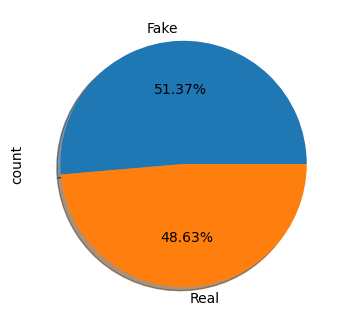

In [13]:
plt.figure(figsize = (6, 4))
df["label"].value_counts().plot(kind = "pie", autopct = "%0.02f%%", shadow = True)
plt.show()

Fake class consists 51% and Real class consists 48.6%.

# ***Data Preprocessing***

In [14]:
# Importing nltk libraries
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# loading the Lemmatizer
wnl = WordNetLemmatizer()

In [15]:
# Calculating the number of words and sentences present in text feature.
df["Word_len"] = df["Text"].apply(lambda x : len(nltk.word_tokenize(x)))
df["Sent_len"] = df["Text"].apply(lambda x : len(nltk.sent_tokenize(x)))

**Text Cleaning**

In [16]:
def text_cleaning(clean):
    rf = re.sub("[^A-Za-z0-9]", " ", clean)
    rf = rf.lower()
    rf = rf.split()
    rf = [wnl.lemmatize(word) for word in rf if not word in set(stopwords.words("english"))]
    rf = " ".join(rf)
    return rf

In [17]:
df["Clean_text"] = df["Text"].apply(text_cleaning)

In [64]:
# Function to remove the duplicates words as well as words that are size of 3 or smaller
def remove_duplicates(duplicate):
    removed = duplicate.split()
    removed = removed[:200]
    removed = list(set([word for word in removed if len(word) > 3]))
    removed = " ".join(removed)
    return removed

df["Fresh_text"] = df["Clean_text"].apply(remove_duplicates)

In [66]:
# Importing wordcloud to see the common words in real and fake
from wordcloud import WordCloud
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = "white")

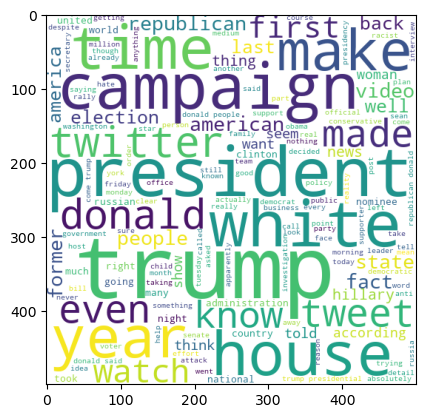

In [67]:
# Common words in Fake class.
span_wc = wc.generate(df[df["label"] == "Fake"]["Fresh_text"].str.cat(sep = " "))
plt.imshow(span_wc)
plt.show()

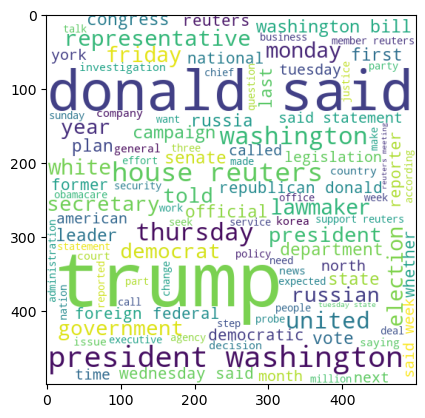

In [68]:
# Common words in Real class
span_wc = wc.generate(df[df["label"] == "Real"]["Fresh_text"].str.cat(sep = " "))
plt.imshow(span_wc)
plt.show()

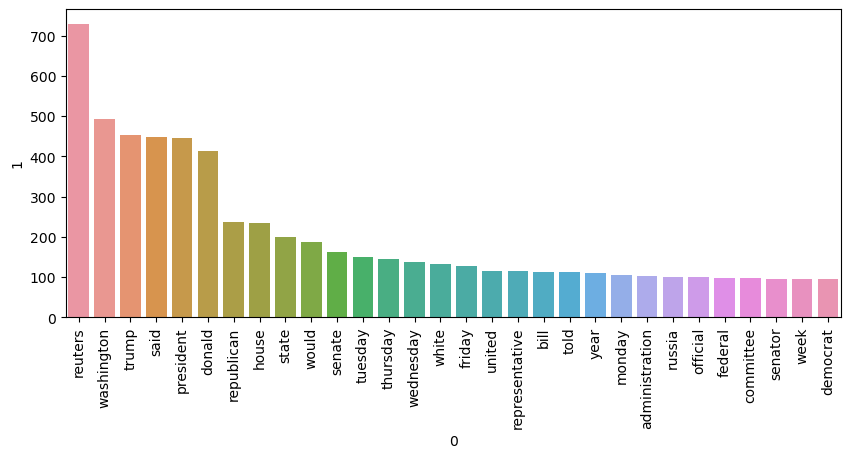

In [69]:
# Fetching the highest 30 values for Real
real_corpus = []
for msg in df[df["label"] == "Real"]["Fresh_text"].to_list():
    for word in msg.split():
        real_corpus.append(word)
        
from collections import Counter      
plt.figure(figsize = (10, 4))
sns.barplot(x = pd.DataFrame(Counter(real_corpus).most_common(30))[0],y = pd.DataFrame(Counter(real_corpus).most_common(30))[1])
plt.xticks(rotation = "vertical")
plt.show()

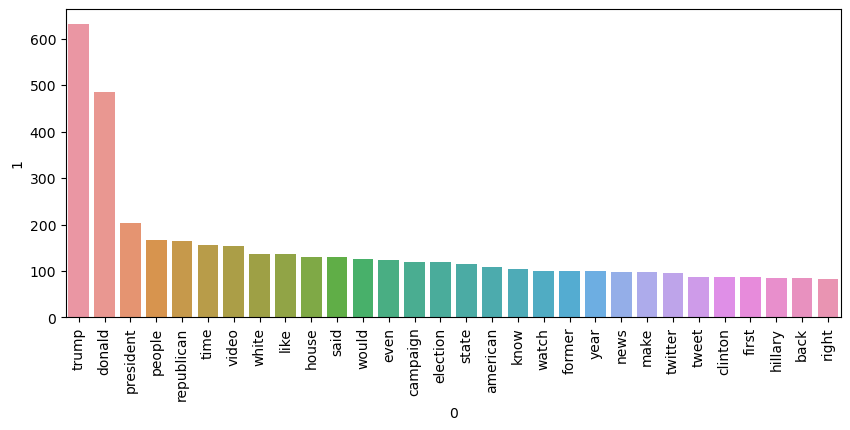

In [70]:
fake_corpus = []
for msg in df[df["label"] == "Fake"]["Fresh_text"].to_list():
    for word in msg.split():
        fake_corpus.append(word)
        
from collections import Counter      
plt.figure(figsize = (10, 4))
sns.barplot(x = pd.DataFrame(Counter(fake_corpus).most_common(30))[0],y = pd.DataFrame(Counter(fake_corpus).most_common(30))[1])
plt.xticks(rotation = "vertical")
plt.show()

**Feature Encoding**

In [112]:
df["label"].replace({"Fake": 0, "Real": 1}, inplace = True)

**Vectorization**

In [71]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

In [72]:
X = cv.fit_transform(df["Fresh_text"]).toarray()

In [113]:
y = df["label"]

**Importing Models & Metrics**

In [126]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB 

**Train Test Split**

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

**GridSearchCV & Model - MultinomialNB**

In [89]:
estimator = MultinomialNB()

param_grid = {"alpha": [0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

grid_model = GridSearchCV(estimator, param_grid, cv = 5, scoring = "accuracy")

grid_model.fit(X_train, y_train)
grid_model.best_params_

{'alpha': 6}

In [116]:
mnb_model = MultinomialNB(alpha = 6)
mnb_model.fit(X_train, y_train)
pred_train = mnb_model.predict(X_train)
pred_test = mnb_model.predict(X_test)

print("Training Accuracy :", accuracy_score(y_train, pred_train))
print("Testing Accuracy :", accuracy_score(y_test, pred_test))
print("ROC AUC Score :", roc_auc_score(y_test, pred_test))

print("Confusion Matrix")
print(confusion_matrix(y_test, pred_test))

print("Classification Report")
print(classification_report(y_test, pred_test))

Training Accuracy : 0.9849874895746455
Testing Accuracy : 0.97
ROC AUC Score : 0.969017094017094
Confusion Matrix
[[136   8]
 [  1 155]]
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       144
           1       0.95      0.99      0.97       156

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



**Model - BernoulliNB**

In [117]:
bnb_model = BernoulliNB()
bnb_model.fit(X_train, y_train)
pred_train = bnb_model.predict(X_train)
pred_test = bnb_model.predict(X_test)

print("Training Accuracy :", accuracy_score(y_train, pred_train))
print("Testing Accuracy :", accuracy_score(y_test, pred_test))
print("ROC AUC Score :", roc_auc_score(y_test, pred_test))

print("Confusion Matrix")
print(confusion_matrix(y_test, pred_test))

print("Classification Report")
print(classification_report(y_test, pred_test))

Training Accuracy : 0.9974979149291076
Testing Accuracy : 0.9866666666666667
ROC AUC Score : 0.9863782051282052
Confusion Matrix
[[141   3]
 [  1 155]]
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       144
           1       0.98      0.99      0.99       156

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



**Model - GaussianNB**

In [118]:
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)
pred_train = gnb_model.predict(X_train)
pred_test = gnb_model.predict(X_test)

print("Training Accuracy :", accuracy_score(y_train, pred_train))
print("Testing Accuracy :", accuracy_score(y_test, pred_test))
print("ROC AUC Score :", roc_auc_score(y_test, pred_test))

print("Confusion Matrix")
print(confusion_matrix(y_test, pred_test))

print("Classification Report")
print(classification_report(y_test, pred_test))

Training Accuracy : 1.0
Testing Accuracy : 0.8866666666666667
ROC AUC Score : 0.889690170940171
Confusion Matrix
[[139   5]
 [ 29 127]]
Classification Report
              precision    recall  f1-score   support

           0       0.83      0.97      0.89       144
           1       0.96      0.81      0.88       156

    accuracy                           0.89       300
   macro avg       0.89      0.89      0.89       300
weighted avg       0.90      0.89      0.89       300



**Model - LogisticRegression**

In [128]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
pred_train = logistic_model.predict(X_train)
pred_test = logistic_model.predict(X_test)

print("Training Accuracy :", accuracy_score(y_train, pred_train))
print("Testing Accuracy :", accuracy_score(y_test, pred_test))
print("ROC AUC Score :", roc_auc_score(y_test, pred_test))

print("Confusion Matrix")
print(confusion_matrix(y_test, pred_test))

print("Classification Report")
print(classification_report(y_test, pred_test))

Training Accuracy : 1.0
Testing Accuracy : 1.0
ROC AUC Score : 1.0
Confusion Matrix
[[144   0]
 [  0 156]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       144
           1       1.00      1.00      1.00       156

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



**Model - SVM**

In [119]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
pred_train = svm_model.predict(X_train)
pred_test = svm_model.predict(X_test)

print("Training Accuracy :", accuracy_score(y_train, pred_train))
print("Testing Accuracy :", accuracy_score(y_test, pred_test))
print("ROC AUC Score :", roc_auc_score(y_test, pred_test))

print("Confusion Matrix")
print(confusion_matrix(y_test, pred_test))

print("Classification Report")
print(classification_report(y_test, pred_test))

Training Accuracy : 1.0
Testing Accuracy : 1.0
ROC AUC Score : 1.0
Confusion Matrix
[[144   0]
 [  0 156]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       144
           1       1.00      1.00      1.00       156

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



**GridSearchCV & Model - DecisionTree**

In [120]:
decision_model = DecisionTreeClassifier()
decision_model.fit(X_train, y_train)
pred_train = decision_model.predict(X_train)
pred_test = decision_model.predict(X_test)

print("Training Accuracy :", accuracy_score(y_train, pred_train))
print("Testing Accuracy :", accuracy_score(y_test, pred_test))
print("ROC AUC Score :", roc_auc_score(y_test, pred_test))

print("Confusion Matrix")
print(confusion_matrix(y_test, pred_test))

print("Classification Report")
print(classification_report(y_test, pred_test))

Training Accuracy : 1.0
Testing Accuracy : 1.0
ROC AUC Score : 1.0
Confusion Matrix
[[144   0]
 [  0 156]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       144
           1       1.00      1.00      1.00       156

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



**GridSearchCV & Model - RandomForestClassifier**

In [106]:
estimator = RandomForestClassifier()

param_grid = {"n_estimators": list(range(9, 20))}

grid_model = GridSearchCV(estimator, param_grid, cv = 5, scoring = "accuracy")

grid_model.fit(X_train, y_train)
grid_model.best_params_

{'n_estimators': 16}

In [121]:
random_model = RandomForestClassifier(n_estimators = 16)
random_model.fit(X_train, y_train)
pred_train = random_model.predict(X_train)
pred_test = random_model.predict(X_test)

print("Training Accuracy :", accuracy_score(y_train, pred_train))
print("Testing Accuracy :", accuracy_score(y_test, pred_test))
print("ROC AUC Score :", roc_auc_score(y_test, pred_test))

print("Confusion Matrix")
print(confusion_matrix(y_test, pred_test))

print("Classification Report")
print(classification_report(y_test, pred_test))

Training Accuracy : 1.0
Testing Accuracy : 0.9866666666666667
ROC AUC Score : 0.9869123931623932
Confusion Matrix
[[143   1]
 [  3 153]]
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       144
           1       0.99      0.98      0.99       156

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



**GridSearchCV & Model - AdaBoostClassifier**

In [122]:
ada_model = AdaBoostClassifier()
ada_model.fit(X_train, y_train)
pred_train = ada_model.predict(X_train)
pred_test = ada_model.predict(X_test)

print("Training Accuracy :", accuracy_score(y_train, pred_train))
print("Testing Accuracy :", accuracy_score(y_test, pred_test))
print("ROC AUC Score :", roc_auc_score(y_test, pred_test))

print("Confusion Matrix")
print(confusion_matrix(y_test, pred_test))

print("Classification Report")
print(classification_report(y_test, pred_test))

Training Accuracy : 1.0
Testing Accuracy : 1.0
ROC AUC Score : 1.0
Confusion Matrix
[[144   0]
 [  0 156]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       144
           1       1.00      1.00      1.00       156

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



**GridSearchCV & Model - GradientBoostingClassifier**

In [123]:
gradient_model = GradientBoostingClassifier()
gradient_model.fit(X_train, y_train)
pred_train = gradient_model.predict(X_train)
pred_test = gradient_model.predict(X_test)

print("Training Accuracy :", accuracy_score(y_train, pred_train))
print("Testing Accuracy :", accuracy_score(y_test, pred_test))
print("ROC AUC Score :", roc_auc_score(y_test, pred_test))

print("Confusion Matrix")
print(confusion_matrix(y_test, pred_test))

print("Classification Report")
print(classification_report(y_test, pred_test))

Training Accuracy : 1.0
Testing Accuracy : 1.0
ROC AUC Score : 1.0
Confusion Matrix
[[144   0]
 [  0 156]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       144
           1       1.00      1.00      1.00       156

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



**GridSearchCV & Model - KNN**

In [83]:
estimator = KNeighborsClassifier()

param_grid = {"n_neighbors": list(range(1, 10))}

grid_model = GridSearchCV(estimator, param_grid, cv = 5, scoring = "accuracy")

grid_model.fit(X_train, y_train)
grid_model.best_params_

{'n_neighbors': 2}

In [124]:
svm_model = KNeighborsClassifier(n_neighbors = 2)
svm_model.fit(X_train, y_train)
pred_train = svm_model.predict(X_train)
pred_test = svm_model.predict(X_test)

print("Training Accuracy :", accuracy_score(y_train, pred_train))
print("Testing Accuracy :", accuracy_score(y_test, pred_test))
print("ROC AUC Score :", roc_auc_score(y_test, pred_test))

print("Confusion Matrix")
print(confusion_matrix(y_test, pred_test))

print("Classification Report")
print(classification_report(y_test, pred_test))

Training Accuracy : 0.9991659716430359
Testing Accuracy : 0.53
ROC AUC Score : 0.5104166666666667
Confusion Matrix
[[  3 141]
 [  0 156]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.02      0.04       144
           1       0.53      1.00      0.69       156

    accuracy                           0.53       300
   macro avg       0.76      0.51      0.36       300
weighted avg       0.75      0.53      0.38       300



# ***Result Interpretation***

In [140]:
accuracy = pd.DataFrame(
    np.array([["MultinomialNB", 98, 97, 96, 97, 97, 97],
             ["BernoulliNB", 99, 98, 98, 99, 99, 99],
             ["GaussianNB", 100, 88, 88, 89, 89, 89],
             ["Logistic",100, 100, 100, 100, 100, 100],
             ["KNN", 99, 53, 51, 76, 51, 36],
             ["SVM", 100, 100, 100, 100, 100, 100],
             ["Decision Tree", 100, 100, 100, 100, 100, 100],
             ["Random Forest", 100, 98, 98, 99, 99, 99],
             ["AdaBoost", 100, 100, 100, 100, 100, 100],
             ["GradientBoosting", 100, 100, 100, 100, 100, 100]
             ]),
    columns = ["Model", "Train Accuracy", "Test Accuracy", "ROC_AUC", "Precision", "Recall", "F1 Score"]
)

accuracy

,Model,Train Accuracy,Test Accuracy,ROC_AUC,Precision,Recall,F1 Score
0,MultinomialNB,98,97,96,97,97,97
1,BernoulliNB,99,98,98,99,99,99
2,GaussianNB,100,88,88,89,89,89
3,Logistic,100,100,100,100,100,100
4,KNN,99,53,51,76,51,36
5,SVM,100,100,100,100,100,100
6,Decision Tree,100,100,100,100,100,100
7,Random Forest,100,98,98,99,99,99
8,AdaBoost,100,100,100,100,100,100
9,GradientBoosting,100,100,100,100,100,100


- Out of 10 algorithms 5 of them were predicting with 100% accuracy. So, we consider any one of them.

# ***Final Model - Logistic Regression***

In [141]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
pred_train = logistic_model.predict(X_train)
pred_test = logistic_model.predict(X_test)

print("Training Accuracy :", accuracy_score(y_train, pred_train))
print("Testing Accuracy :", accuracy_score(y_test, pred_test))
print("ROC AUC Score :", roc_auc_score(y_test, pred_test))

print("Confusion Matrix")
print(confusion_matrix(y_test, pred_test))

print("Classification Report")
print(classification_report(y_test, pred_test))

Training Accuracy : 1.0
Testing Accuracy : 1.0
ROC AUC Score : 1.0
Confusion Matrix
[[144   0]
 [  0 156]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       144
           1       1.00      1.00      1.00       156

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



**Predicting New Value**

In [183]:
news = input("Enter the news :")

new_data = pd.DataFrame({"news": news}, index = [0])

def clean_texting(text):
    rf = re.sub("[^A-Za-z0-9]", " ", text)
    rf = rf.lower()
    rf = rf.split()
    rf = [wnl.lemmatize(word) for word in rf if not word in set(stopwords.words("english"))]
    rf = " ".join(rf)
    return rf

new_data["news"] = new_data["news"].apply(clean_texting)

nm = cv.transform(new_data["news"]).toarray()

result = logistic_model.predict(nm)[0]

if result == 0:
    print("This news is fake.")
elif result == 1:
    print("This news is real.")

Enter the news : South Korea expects arms, shale gas on U.S.


This news is fake.


In [182]:
df[df["label"] == 1]

,Text,label,Word_len,Sent_len,Clean_text,Fresh_text
1,China defends ally Pakistan after Trump critic...,1,375,11,china defends ally pakistan trump criticism be...,committed safe afghan trump lose vowing others...
4,U.S. lawmakers seek looser energy development ...,1,459,15,u lawmaker seek looser energy development rule...,land american indian ease trump seek looser na...
7,Trump to hold town hall meeting with about 50 ...,1,438,10,trump hold town hall meeting 50 business leade...,trump discussion mastercard plan involve moder...
8,Senate Republicans complain of chaos in health...,1,931,28,senate republican complain chaos healthcare ef...,replace obamacare late revive trump goal chaos...
9,Deputy attorney general seeks meeting with top...,1,107,3,deputy attorney general seek meeting top senat...,russian come trump seen seek reported politico...
...,...,...,...,...,...,...
1488,U.S. rescinds Obama plan for some undocumented...,1,364,12,u rescinds obama plan undocumented parent reut...,resident part signed rescinding immigrant anno...
1492,"South Korea expects arms, shale gas on U.S. ag...",1,289,7,south korea expects arm shale gas u agenda tra...,came trump import trade friday president agend...
1496,"As Trump seeks defense-spending boost, watchdo...",1,1480,53,trump seek defense spending boost watchdog cit...,pentagon experience faulty planning inspector ...
1498,Top U.S. general in Afghanistan says new strat...,1,127,4,top u general afghanistan say new strategy bas...,part trump presence based arbitrary night troo...
